# Learning a macroscale PDE with a Neural Network 

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Activation
from scipy.interpolate import interp1d as interp1d
from matplotlib import cm
from sklearn.model_selection import train_test_split
from tensorflow.keras import regularizers
import time

In [2]:
seed0 = 8 #6
tf.keras.utils.set_random_seed(seed0) 
tf.config.experimental.enable_op_determinism()

### Importing Data and pre-processing

Importing: x, t, b, bx, bxx, c, cx, cxx, bt, ct

x = 0.5:0.5:1000    (2000 points in space)  
t = 200:0.1:300   (1001  profiles)

In [3]:
b_0 = np.loadtxt('Data/b.txt')[1:,1:]
bt_0 = np.loadtxt('Data/bt.txt')[1:,1:]
bx_0 = np.loadtxt('Data/bx.txt')[1:,1:]
bxx_0 = np.loadtxt('Data/bxx.txt')[1:,1:]
c_0 = np.loadtxt('Data/c.txt')[1:,1:]
ct_0 = np.loadtxt('Data/ct.txt')[1:,1:]
cx_0 = np.loadtxt('Data/cx.txt')[1:,1:]
cxx_0 = np.loadtxt('Data/cxx.txt')[1:,1:]
r_ar_0 = np.loadtxt('Data/x.txt')[1:,0]
t_ar_0 = np.loadtxt('Data/t.txt')[0,1:]


NR0 = r_ar_0.shape[0]
NT0 = t_ar_0.shape[0]

In [4]:
laplb = np.zeros(b_0.shape)
laplc = np.zeros(c_0.shape)

for i in range(NT0):
    laplb[:,i] = bxx_0[:,i] + bx_0[:,i]/r_ar_0
    laplc[:,i] = cxx_0[:,i] + cx_0[:,i]/r_ar_0

rhs_0 = np.concatenate(([b_0.T], [bx_0.T], [laplb.T], [c_0.T], [cx_0.T], [laplc.T]), axis=0)

In [5]:
rmin, rmax = 1, 500
tmin, tmax = 0, -700
Nr=1
Nt=10

r_ar_1=r_ar_0[rmin:rmax:Nr]
t_ar_1=t_ar_0[tmin:tmax:Nt]

NR1, NT1=r_ar_1.shape[0], t_ar_1.shape[0]

In [6]:
bt_1 = bt_0.T[tmin:tmax:Nt, rmin:rmax:Nr]
ct_1 = ct_0.T[tmin:tmax:Nt, rmin:rmax:Nr]

rhs_1 = rhs_0[:,tmin:tmax:Nt, rmin:rmax:Nr]

### Boundary Conditions

In [7]:
leftbc_b= interp1d(t_ar_0, rhs_0[0,:,rmin-1], kind='linear')
rightbc_b= interp1d(t_ar_0, rhs_0[0,:,rmax], kind='linear')

leftbc_c= interp1d(t_ar_0, rhs_0[3,:,rmin-1], kind='linear')
rightbc_c= interp1d(t_ar_0, rhs_0[3,:,rmax], kind='quadratic')

In [8]:
cp_bt=np.hstack((np.ravel(bt_1)))

cp_rhs= np.reshape(rhs_1, (6, NT1*NR1)).T

### Normalization

In [9]:
Norm_in=np.copy(cp_rhs)

Norm_in_mu = np.mean(Norm_in, axis=0) #np.zeros(6)

Norm_in_si = np.std(Norm_in, axis=0, ddof=1) #np.ones(6)

for i in range(6):
    Norm_in[:,i]=(cp_rhs[:,i]-Norm_in_mu[i])/Norm_in_si[i]
    
    
Norm_out=np.copy(cp_bt)

Norm_out_mu=np.mean(Norm_out)

Norm_out_si=np.std(Norm_out, ddof=1)

Norm_out=(cp_bt-Norm_out_mu)/Norm_out_si

In [10]:
input_data=Norm_in
target_data=Norm_out

### NN Training

In [11]:
np.random.seed(seed0)

INP_train, INP_test, BT_train, BT_test = train_test_split(input_data ,target_data, train_size=7/8)

In [12]:
def predict_u_net(n_input: int,
                  n_units: int=32):
    
    
    """ A feed-forward model for predicting u from some observables.
    
    Args:
        n_input: number of observables (e.g. pointwise measurements) + 1 (bc x value)
        n_units: number of units within each dense layer

    Returns:
        tf.keras.model that maps observables to u,u_x,... at x
    """

    u=tf.keras.Input(shape=(n_input,),name="observables_and_x")

    dlayer1 = Dense(n_units,activation='tanh',name='dense_1')
    u1 = dlayer1(u)
    
    dlayer2 = Dense(n_units,activation='tanh',name='dense_2')
    u2 = dlayer2(u1)
    
    dlayer3 = Dense(1,activation='linear',name='dense_3')
    u3 = dlayer3(u2)
    
    return tf.keras.Model(u,u3)


uder_model= predict_u_net(6,25)
uder_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 observables_and_x (InputLa  [(None, 6)]               0         
 yer)                                                            
                                                                 
 dense_1 (Dense)             (None, 25)                175       
                                                                 
 dense_2 (Dense)             (None, 25)                650       
                                                                 
 dense_3 (Dense)             (None, 1)                 26        
                                                                 
Total params: 851 (3.32 KB)
Trainable params: 851 (3.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [13]:
# compile the model
adamsky=tf.keras.optimizers.Adam(learning_rate=0.001) #0.0005
uder_model.compile(optimizer=adamsky,loss='mse')
batch_size=  int(15469/1) #30000
epochs = 256*15

In [14]:
time_t1 = time.time()

train_history=uder_model.fit(INP_train,BT_train,
        batch_size=batch_size,epochs=epochs,
        verbose=0,validation_split=.05)

time_t2 = time.time()

In [15]:
'Training time: ', time_t2-time_t1, 31.435433864593506

('Training time: ', 67.54047632217407, 31.435433864593506)

<IPython.core.display.Javascript object>


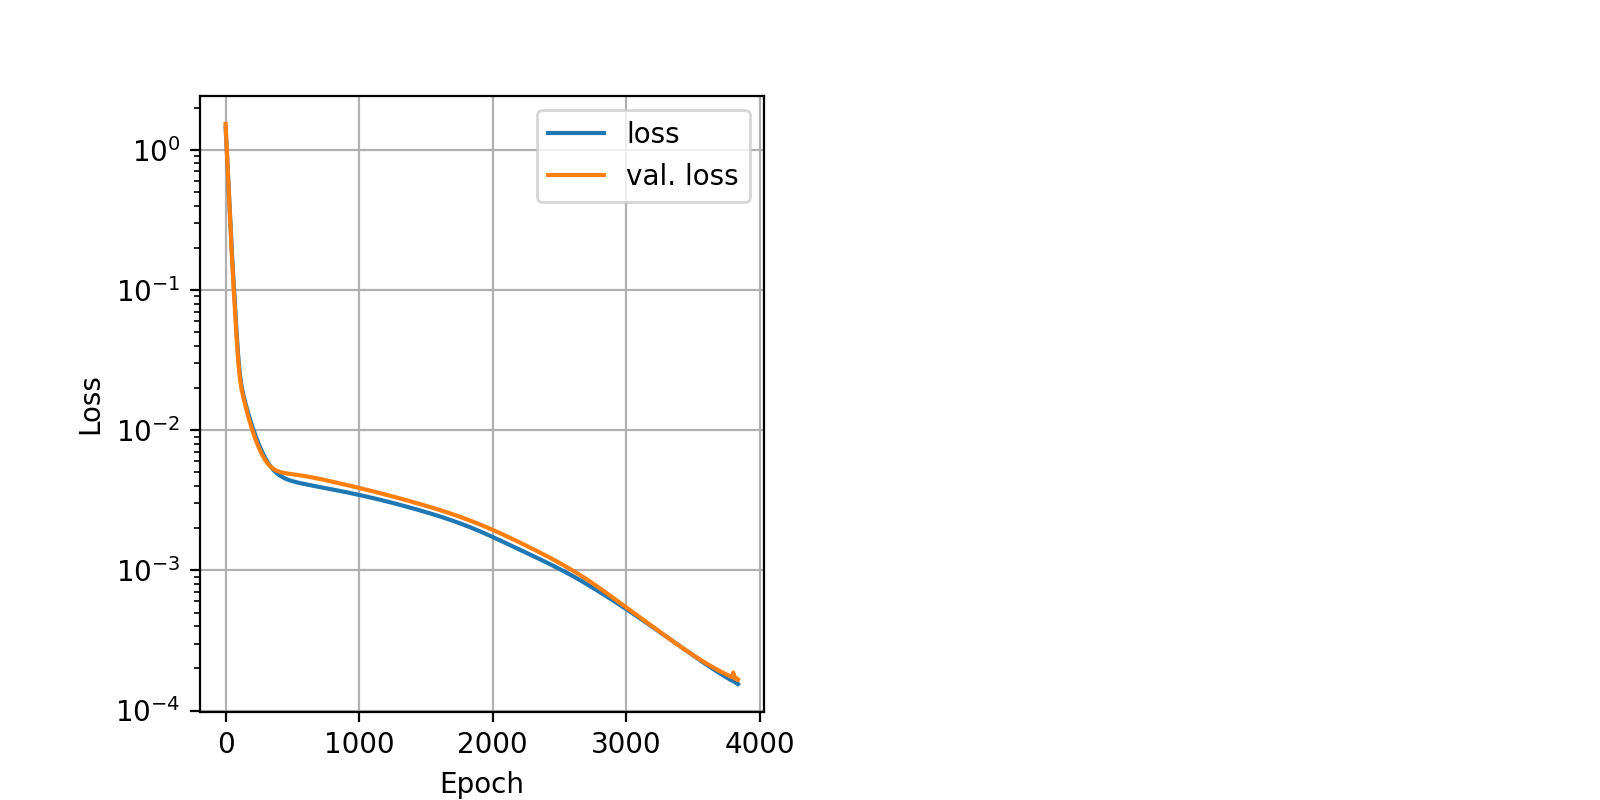

In [16]:
# traiining history
plt.figure(figsize=[8,4])
plt.subplot(1,2,1)
plt.plot(train_history.history['loss'],label='loss')
plt.plot(train_history.history['val_loss'],label='val. loss')
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()

In [17]:
eval_loss_raw0 = uder_model.evaluate(INP_test, BT_test, batch_size=INP_test.shape[0],verbose=0)
eval_loss0 = eval_loss_raw0/np.std(BT_test, ddof=1)
print('Relative Test Loss:', eval_loss0)
print ('Test Loss:', eval_loss_raw0)
print('Training Loss: ',train_history.history['loss'][-1])
print('Validation Loss: ', train_history.history['val_loss'][-1])

Relative Test Loss: 0.00013417115018545529
Test Loss: 0.00013363661128096282
Training Loss:  0.00015456503024324775
Validation Loss:  0.00016587124264333397


### NN Postprocessing - PDE Definition

Features: b, bx, bxx, c, cx, cxx  


In [18]:
def b_to_input_vec(b, c, t, r_array):
    
    dx=0.5
    
    Resx=b.shape[0]

    ders=np.zeros([Resx, 6])
    ders2=np.zeros([Resx, 6])
    
    ders[:,0]=b    
    
    ders[1:-1,1]=(b[2:]-b[:-2])/dx/2
    ders[0,1]=(b[1]-leftbc_b(t))/dx/2
    ders[-1,1]=0
    
    ders[1:-1,2]=(b[2:]-2*b[1:-1]+b[:-2])/dx**2
    ders[0,2]= (b[1]-2*b[0]+leftbc_b(t))/dx**2
    ders[-1,2]= 2*(b[-2]-b[-1])/dx**2
    
    ders[:,3]=c
    
    ders[1:-1,4]=(c[2:]-c[:-2])/dx/2
    ders[0,4]= (c[1]-leftbc_c(t))/2/dx
    ders[-1,4]= (rightbc_c(t)-c[-2])/2/dx
    
    ders[1:-1,5]=(c[2:]-2*c[1:-1]+c[:-2])/dx**2
    ders[0,5]= (c[1]-2*c[0]+leftbc_c(t))/dx**2
    ders[-1,5]= (c[-2]-2*c[-1]+rightbc_c(t))/dx**2
    
    ders1 = np.copy(ders)
    ders1[:,2]= ders[:,2]+ders[:,1]/r_array
    ders1[:,5]= ders[:,5]+ders[:,4]/r_array
    
    for i in range(6):
        ders2[:,i]=(ders1[:,i]-Norm_in_mu[i])/Norm_in_si[i]

    return ders2

def right_hand_side(t,x, r_ar_1):
    
    Nv= int(x.shape[0]/2)
    
    bt_dd=np.zeros(Nv)
    ct_dd=np.zeros(Nv)
    
    b_temp = x[:Nv]
    c_temp = x[Nv:]
        
    c_char = 1
    k = 3000
    D_c=800
        
    input_matrix=b_to_input_vec(b_temp, c_temp, t, r_ar_1)
        
        
    bt_dd = np.ravel(uder_model.predict(np.array(input_matrix),  verbose=0)*Norm_out_si+Norm_out_mu)
    
    dif_norm=input_matrix[:,5]*Norm_in_si[5]+Norm_in_mu[5]
    
    ct_dd = D_c * dif_norm - k * b_temp *  c_temp / (c_temp*10000 + c_char)

    
    return np.concatenate((bt_dd , ct_dd))

### Testing what NN learned

<IPython.core.display.Javascript object>


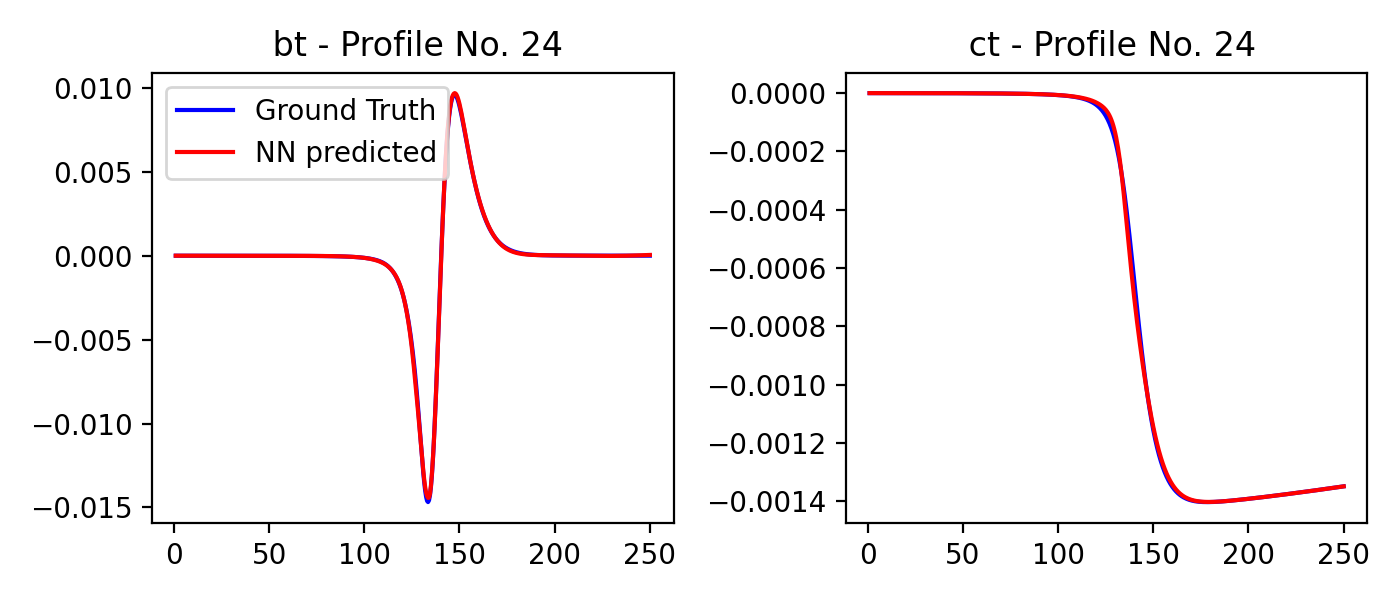

In [19]:
fig, ax=plt.subplots(nrows=1, ncols=2, tight_layout=True, figsize=[7,3])

ind1=np.random.randint(NT1)
# ind1=0
# print(NT1)

ax[0].set_title( ' bt - Profile No. '+str(ind1))
ax[1].set_title( ' ct - Profile No. '+str(ind1))

state_temp=np.concatenate((rhs_1[0,ind1,:], rhs_1[3,ind1,:] ))

ax[0].plot(r_ar_1,bt_1[ind1,:], c='blue', label='Ground Truth')
ax[0].plot(r_ar_1, right_hand_side(t_ar_1[ind1],state_temp, r_ar_1)[:NR1], c='red', label='NN predicted')
ax[1].plot(r_ar_1,ct_1[ind1,:], c='blue', label='Ground Truth')
ax[1].plot(r_ar_1, right_hand_side(t_ar_1[ind1],state_temp, r_ar_1)[NR1:], c='red', label='NN predicted')


ax[0].legend()

<IPython.core.display.Javascript object>


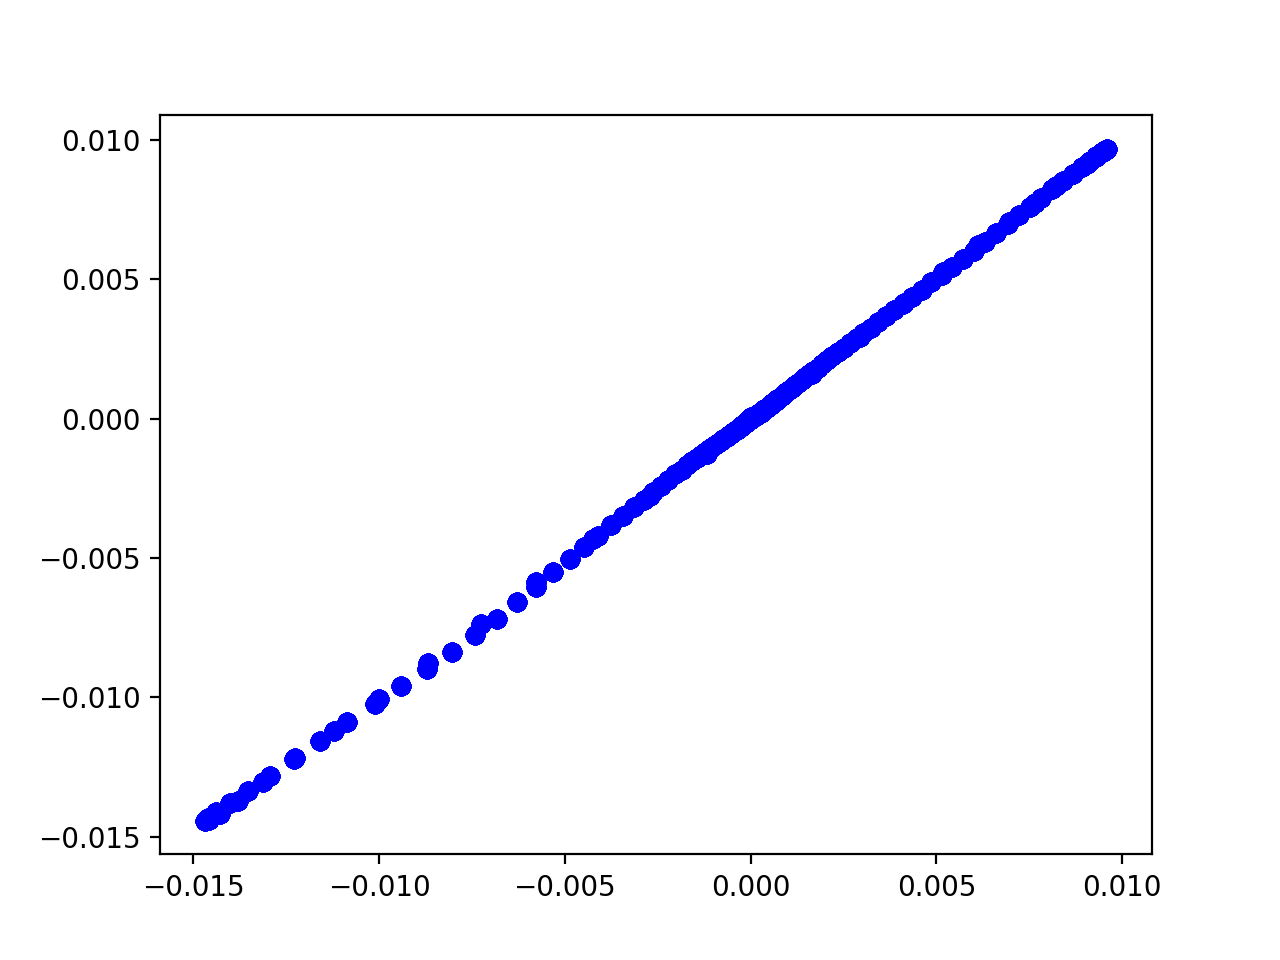

<IPython.core.display.Javascript object>


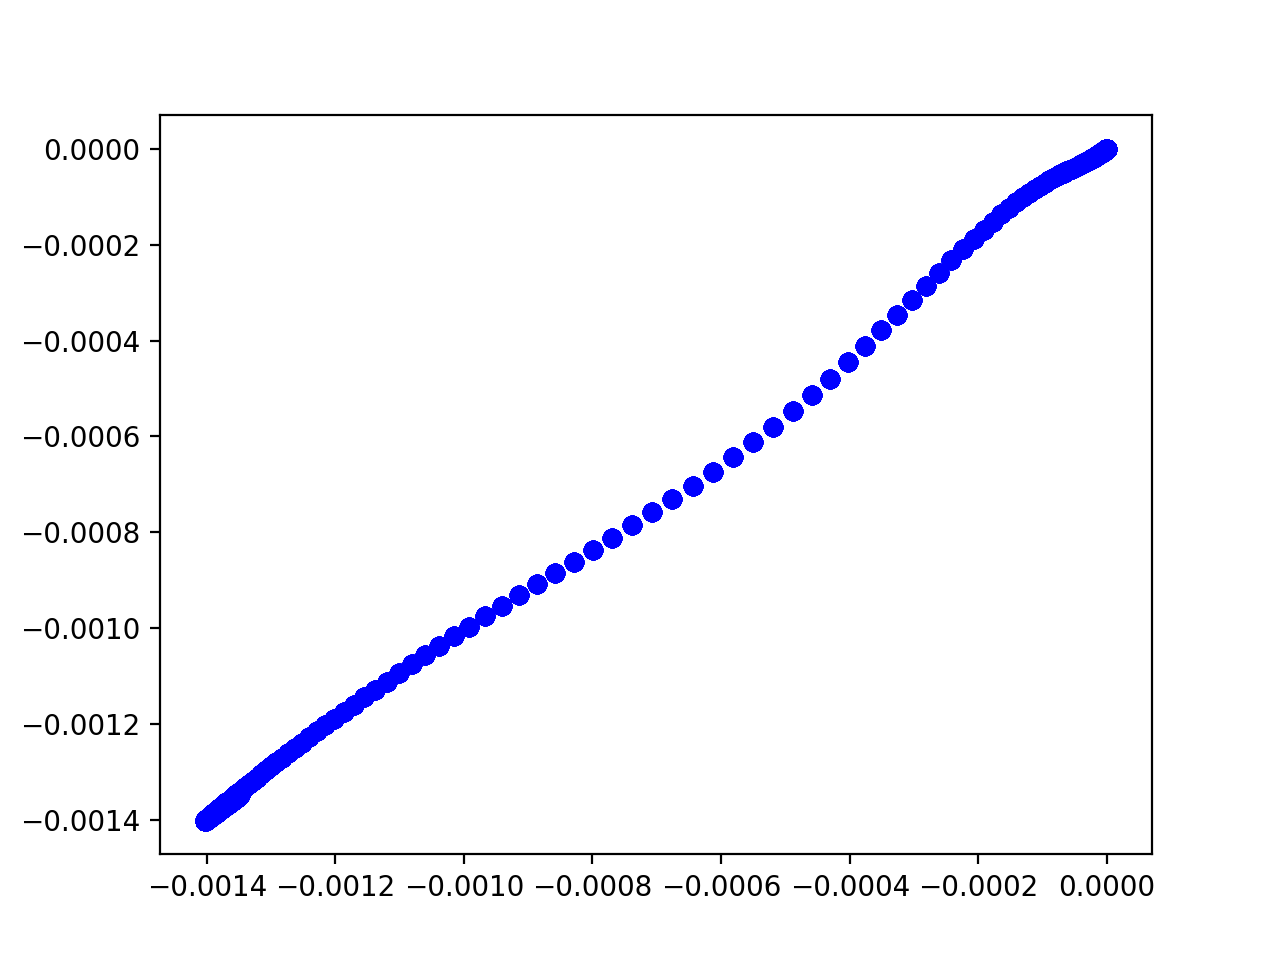

In [20]:
fig, ax = plt.subplots()
for i in range(NT1):
    ax.scatter(bt_1[ind1,:], right_hand_side(t_ar_1[ind1],state_temp, r_ar_1)[:NR1], c='b')
    
fig, ax = plt.subplots()

for i in range(NT1):
    ax.scatter(ct_1[ind1,:], right_hand_side(t_ar_1[ind1],state_temp, r_ar_1)[NR1:], c='b')

### Save the NN and Data

In [21]:
uder_model.save('BBModel')

INFO:tensorflow:Assets written to: BBModel/assets


INFO:tensorflow:Assets written to: BBModel/assets
